## PyMilvus dev

In [72]:
from semantic_search.utils import load_metadata
from importlib import reload

df, ref_df = load_metadata(
    '/Users/luis/Desktop/ETH/Courses/SS25-DSL/raw-data/metadata3',
    filter_good_papers=True,
    filter_good_references=True
)
ref_df.rename(columns={'oaid': 'id', 'abstract': 'text'}, inplace=True)

In [56]:
# from pymilvus import MilvusClient
# client = MilvusClient()
# client.close()


In [210]:
from semantic_search.store import models, milvus_store
reload(models)
reload(milvus_store)
from semantic_search.store.models import LocalEmbeddingModel
from semantic_search.store.milvus_store import MilvusDocumentStore

# if (ds := getattr(locals(), 'ds', None)) is not None:
#     print('Disconnecting client')
#     ds._disconnect_client()
ds = MilvusDocumentStore(
    model=LocalEmbeddingModel(), 
    db_dir='/Users/luis/Desktop/ETH/Courses/SS25-DSL/db/milvus-dev1',
    store_documents=True
)

Using device: mps


In [211]:
ds.check_server_health()

True

In [212]:
# if not ds.load_store():
ds.create_index_from_df(ref_df.rename(columns={'oaid': 'id', 'abstract': 'text'}).iloc[:1000], overwrite=True)

Chunking and encoding: 100%|██████████| 1000/1000 [00:01<00:00, 940.97it/s]


Generating embeddings for 1663 chunks...


Generating embeddings: 100%|██████████| 208/208 [00:09<00:00, 21.51it/s]


Inserting 1663 chunks into Milvus...
Indexed 1000 documents in Milvus


In [209]:
ds.search('Deep residual networks', top_k=10, return_scores=True, return_doc_metadata=False, search_type='hybrid')

[{'rank': 1, 'id': 'W2964137095', 'score': 0.8996273875236511},
 {'rank': 2, 'id': 'W2194775991', 'score': 0.8761672973632812},
 {'rank': 3, 'id': 'W2620983607', 'score': 0.8486814498901367},
 {'rank': 4, 'id': 'W3034997257', 'score': 0.8431603908538818},
 {'rank': 5, 'id': 'W2508457857', 'score': 0.840130090713501},
 {'rank': 6, 'id': 'W3016719260', 'score': 0.8333098888397217},
 {'rank': 7, 'id': 'W2981918755', 'score': 0.8289320468902588},
 {'rank': 8, 'id': 'W2928165649', 'score': 0.8257160782814026},
 {'rank': 9, 'id': 'W2124592697', 'score': 0.8091139793395996},
 {'rank': 10, 'id': 'W2962741876', 'score': 0.8059472441673279}]

In [111]:
from semantic_search.benchmarking import utils
reload(utils)

<module 'semantic_search.benchmarking.utils' from '/Users/luis/Desktop/ETH/Courses/SS25-DSL/src/semantic_search/benchmarking/utils.py'>

In [118]:
from semantic_search.data_retrieval.utils import extract_abstract_from_md
from semantic_search.utils import predict_refs_from_abstract
from semantic_search.benchmarking.utils import calc_metric_at_levels
from tqdm import tqdm
import pandas as pd

first_n_papers = 20
search_kwargs = {'search_type': 'hybrid'}


df, ref_df = load_metadata(
    '/Users/luis/Desktop/ETH/Courses/SS25-DSL/raw-data/metadata3',
    filter_good_papers=True,
    filter_good_references=True
)
# ref_df.rename(columns={'oaid': 'id', 'abstract': 'text'}, inplace=True)
df['fpath'] = df['fpath'].str.replace('/cluster/home/lcarretero/workspace/dsl/dsl-research-assistant', '/Users/luis/Desktop/ETH/Courses/SS25-DSL')
df['abstract'] = df['fpath'].apply(extract_abstract_from_md)
df = df[df.abstract.apply(len) > 0]
df = df.iloc[:first_n_papers]

available_refs = set(ref_df['oaid'].iloc[:1000].str.lower().values)
df['GT_refs'] = df.refs_oaids_from_dois.apply(lambda refs: [ref for ref in refs if ref in available_refs])
df['available_ref_ratio'] = df.GT_refs.apply(len) / df.refs_oaids_from_dois.apply(len)

ref_cnt = int(df.GT_refs.apply(len).mean())
max_n_refs = 200
ref_cnts = list(range(1, max_n_refs + 1))

results = []
for i, row in tqdm(df.iterrows(), total=len(df), desc='Predicting references'):
    pred = predict_refs_from_abstract(ds, row['abstract'], max_n_refs=max_n_refs, search_kwargs=search_kwargs)
    metrics = calc_metric_at_levels(row['GT_refs'], pred, ref_cnts, ref_cnt)
    results.append(metrics)
results_df = pd.DataFrame(results)

Predicting references: 100%|██████████| 20/20 [00:01<00:00, 14.03it/s]


In [125]:
mean_metrics

ref_cnt           200.000000
prec_lvl1           0.500000
rec_lvl1           -0.015620
f1_lvl1             0.012616
prec_lvl2           0.425000
                     ...    
rec_lvl200          0.688230
f1_lvl200           0.079617
prec_preflvl19      0.307895
rec_preflvl19       0.281289
f1_preflvl19        0.250494
Length: 604, dtype: float64

In [132]:
mean_metrics

prec_lvl1      0.578947
rec_lvl1       0.036190
f1_lvl1        0.065912
prec_lvl2      0.500000
rec_lvl2       0.051232
                 ...   
rec_lvl199     0.777084
f1_lvl199      0.137024
prec_lvl200    0.080526
rec_lvl200     0.777084
f1_lvl200      0.136439
Length: 600, dtype: float64

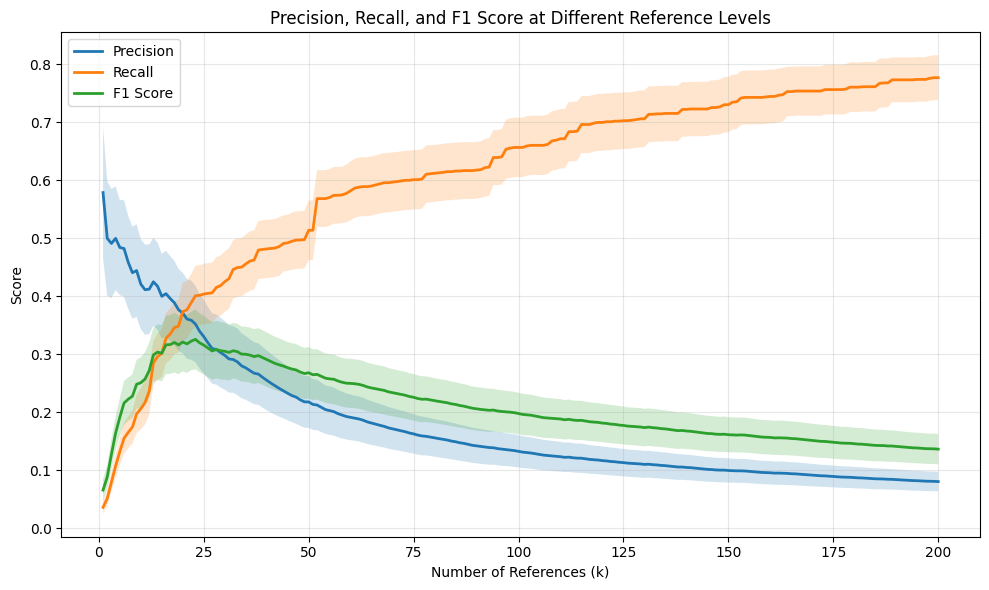

In [134]:
import numpy as np
import matplotlib.pyplot as plt

results_df2 = results_df[results_df.prec_lvl1 != -1].iloc[:, 1:-3]

mean_metrics = results_df2.mean(axis=0)
err_metrics = results_df2.std(axis=0) / np.sqrt(len(df))

# Extract metrics for different levels
levels = []
precision_values = []
recall_values = []
f1_values = []
precision_err = []
recall_err = []
f1_err = []

max_level = max([int(name.split('lvl')[-1]) for name in mean_metrics.index.tolist() if name.startswith('prec_lvl')])
for level in range(1, max_level + 1):
    level_str = f'lvl{level}'
    if f'prec_{level_str}' in mean_metrics:
        levels.append(level)
        precision_values.append(mean_metrics[f'prec_{level_str}'])
        recall_values.append(mean_metrics[f'rec_{level_str}'])
        f1_values.append(mean_metrics[f'f1_{level_str}'])
        precision_err.append(err_metrics[f'prec_{level_str}'])
        recall_err.append(err_metrics[f'rec_{level_str}'])
        f1_err.append(err_metrics[f'f1_{level_str}'])

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(levels, precision_values, label='Precision', marker='', linewidth=2)
plt.fill_between(levels, np.array(precision_values) - np.array(precision_err), 
                 np.array(precision_values) + np.array(precision_err), alpha=0.2)
plt.plot(levels, recall_values, label='Recall', marker='', linewidth=2)
plt.fill_between(levels, np.array(recall_values) - np.array(recall_err), 
                 np.array(recall_values) + np.array(recall_err), alpha=0.2)
plt.plot(levels, f1_values, label='F1 Score', marker='', linewidth=2)
plt.fill_between(levels, np.array(f1_values) - np.array(f1_err), 
                 np.array(f1_values) + np.array(f1_err), alpha=0.2)

plt.xlabel('Number of References (k)')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score at Different Reference Levels')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

## Embedding dev (tokenisation, embedding and pooling)

In [6]:
from importlib import reload
from semantic_search import store
reload(store)
from semantic_search.store.models import LocalEmbeddingModel

model = LocalEmbeddingModel()

Using device: cpu


In [5]:
model.embedding_dim

384

In [234]:
import torch

tmp_input = "Using pooling, it generates from a variable sized sentence a fixed sized sentence embedding. This layer also allows to use the CLS token if it is returned by the underlying word embedding model. You can concatenate multiple poolings together."

inputs = [tmp_input*10, tmp_input*3, tmp_input, tmp_input*30]

_, all_chunks_encoded = model.chunk_and_encode(inputs, progress_bar=True)

# Flatten encoded
tmp = {}
for single_text_encoded in all_chunks_encoded:
    for k, v in single_text_encoded.items():
        if k not in tmp:
            tmp[k] = []
        tmp[k].append(v)
encoded_flattened = {k: torch.cat(v) for k, v in tmp.items()}

# Get embeddings for all chunks
print(f"Generating embeddings for {len(list(encoded_flattened.values())[0])} chunks...")
embeddings = model.get_embeddings(encoded_flattened, progress_bar=True)

Chunking and encoding: 100%|██████████| 4/4 [00:00<00:00, 585.61it/s]


Generating embeddings for 8 chunks...


Generating embeddings: 100%|██████████| 1/1 [00:02<00:00,  2.76s/it]


In [231]:
from torch.nn import functional as F

_, encoded = model.chunk_and_encode(tmp_input*100)
emb = model.get_embeddings(encoded)


encoded_input = model.tokenizer(tmp_input*100, padding=True, truncation=True, return_tensors='pt')

# Compute token embeddings
with torch.no_grad():
    model_output = model.model(**encoded_input)

# Perform pooling
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

# Normalize embeddings
sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)



In [232]:
emb[0] == sentence_embeddings[0]

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, Tr

In [1]:
from semantic_search.utils import load_metadata

df, ref_df = load_metadata(
    '/Users/luis/Desktop/ETH/Courses/SS25-DSL/raw-data/metadata3',
    filter_good_papers=True,
    filter_good_references=True
)

In [3]:
ref_df['']

,oaid,doi,ref_via,title,abstract,type,topic,domain,field,subfield
0,W2194775991,10.1109/cvpr.2016.90,openalex_id,Deep Residual Learning for Image Recognition,Deeper neural networks are more difficult to t...,article,Advanced Neural Network Applications,Physical Sciences,Computer Science,Computer Vision and Pattern Recognition


In [2]:
# Running below in REPL works

import os

# Set PyTerrier home directory
os.environ['PYTERRIER_HOME'] = '/Users/luis/Desktop/ETH/Courses/SS25-DSL/src/semantic_search/dev'
os.environ['TMPDIR'] = '/Users/luis/Desktop/ETH/Courses/SS25-DSL/src/semantic_search/dev/tmp'

import pyterrier as pt
import pandas as pd

if not pt.started(): pt.init(home_dir='/Users/luis/Desktop/ETH/Courses/SS25-DSL/src/semantic_search/dev')

# import your documents into an index
# Create a pandas DataFrame with the documents

doc_texts = ref_df.abstract

docs_df = pd.DataFrame({
    'docno': [str(i) for i in range(len(doc_texts))],
    'text': doc_texts
})

# Use IterDictIndexer instead of TerrierIndexer
indexer = pt.IterDictIndexer('/Users/luis/Desktop/ETH/Courses/SS25-DSL/src/semantic_search/dev/terrier_index')
index_ref = indexer.index(docs_df.to_dict('records'))

bm25 = pt.BatchRetrieve(index_ref, wmodel="BM25")
results = bm25.transform(pt.Utils.prepare_qrels(pd.DataFrame({'qid':['q1'], 'query':['your keywords here']})))
print(results[['qid', 'docno', 'score']])

/scratch/tmp.31851532.lcarretero/ipykernel_946913/2934055006.py:11: DeprecationWarning: Call to deprecated function (or staticmethod) started. (use pt.java.started() instead) -- Deprecated since version 0.11.0.
  if not pt.started(): pt.init(home_dir='/cluster/home/lcarretero/workspace/dsl/dsl-research-assistant/src/semantic_search/dev')


terrier-assemblies 5.11 jar-with-dependencies not found, downloading to /cluster/home/lcarretero/workspace/dsl/dsl-research-assistant/src/semantic_search/dev...


PermissionError: [Errno 13] Permission denied: '/terrier-assemblies-5.11-jar-with-dependencies.jar4pglkysh.tmp'

## Dev for new cleaner store setup

In [1]:
from importlib import reload
from semantic_search.store import store
reload(store)
from semantic_search.store.store import FAISSDocumentStore
from tqdm import tqdm

Exception: Unable to find javac

In [2]:
ds = FAISSDocumentStore(db_dir='/Users/luis/Desktop/ETH/Courses/SS25-DSL/db/hybrid-dev3')
assert ds.load_store()

2025-05-13 12:32:08.412831: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-13 12:32:09.511891: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-13 12:32:11.497976: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Using device: cpu
Loaded index with 41220 vectors


In [7]:
ds.search('Deep residual networks', top_k=10, retrieval_method='hybrid')

[{'rank': 1,
  'id': 'W2964137095',
  'doi': '10.5244/c.30.87',
  'ref_via': 'openalex_id',
  'title': 'Wide Residual Networks',
  'text': 'Deep residual networks were shown to be able to scale up to thousands of layers and still have improving performance. However, each fraction of a percent of improved accuracy costs nearly doubling the number of layers, and so training very deep residual networks has a problem of diminishing feature reuse, which makes these networks very slow to train. To tackle these problems, in this paper we conduct a detailed experimental study on the architecture of ResNet blocks, based on which we propose a novel architecture where we decrease depth and increase width of residual networks. We call the resulting network structures wide residual networks (WRNs) and show that these are far superior over their commonly used thin and very deep counterparts. For example, we demonstrate that even a simple 16-layer-deep wide residual network outperforms in accuracy an